In [1]:
# === PASO 1: Limpieza y combinación de bases ===
import pandas as pd

# Cargar archivos CSV
clientes = pd.read_csv('base_clientes_final.csv')
transacciones = pd.read_csv('base_transacciones_final.csv')

# Limpiar nombres de columnas por si acaso
clientes.rename(columns=lambda x: x.strip(), inplace=True)
transacciones.rename(columns=lambda x: x.strip(), inplace=True)

# Combinar las bases usando 'id',,,
base_completa = transacciones.merge(clientes, on='id', how='left')

# Llenar nulos en giro_comercio
base_completa['giro_comercio'].fillna("SIN CLASIFICAR", inplace=True)

# Vista previa
print("Vista previa de la base combinada:")
print(base_completa.head())

# Guardar base combinada
base_completa.to_csv('base_completa.csv', index=False)
print("\n¡Archivo guardado como 'base_completa.csv'!")


Vista previa de la base combinada:
                                         id       fecha comercio  \
0  91477f382c3cf63ab5cd9263b502109243741158  2022-01-02   AMAZON   
1  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05    RAPPI   
2  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05    RAPPI   
3  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05   AMAZON   
4  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05   AMAZON   

                                giro_comercio tipo_venta  monto  \
0  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   5.99   
1   SERVICIOS EMPRESARIALES - NO CLASIFICADOS    digital  13.01   
2   SERVICIOS EMPRESARIALES - NO CLASIFICADOS    digital  15.84   
3  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   8.17   
4  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   

  fecha_nacimiento  fecha_alta  id_municipio  id_estado  \
0       1987-09-21  2019-10-28       6519019         65   
1       1987-09-21  2019-10-28     

In [2]:
# PASO 2: Calcular meses_distintos por cliente–comercio
# Asegurarse que la fecha sea tipo datetime
base_completa['fecha'] = pd.to_datetime(base_completa['fecha'])

# Crear columna año-mes
base_completa['año_mes'] = base_completa['fecha'].dt.to_period('M')

# Agrupar por cliente y comercio para contar meses distintos
frecuencia_mensual = (
    base_completa.groupby(['id', 'comercio'])['año_mes']
    .nunique()
    .reset_index(name='meses_distintos')
)


In [17]:
# Asegúrate de que 'fecha' esté en formato datetime
base_completa['fecha'] = pd.to_datetime(base_completa['fecha'])

# Obtener la fecha máxima del dataset
fecha_max = base_completa['fecha'].max()

# Calcular el umbral de 3 meses atrás
umbral_tres_meses = fecha_max - pd.DateOffset(months=3)

# Filtrar solo las transacciones de los últimos 3 meses
base_ultimos_meses = base_completa[base_completa['fecha'] >= umbral_tres_meses].copy()

# Crear columna con el número de semana (formato ISO: año-semana)
base_ultimos_meses['año_semana'] = base_ultimos_meses['fecha'].dt.strftime('%Y-%U')


In [18]:
# Paso 1: contar compras por usuario y semana
compras_por_semana = (
    base_ultimos_meses.groupby(['id', 'año_semana'])
    .size()
    .reset_index(name='compras_en_semana')
)

# Paso 2: filtrar semanas con al menos 2 compras
semanas_validas = compras_por_semana[compras_por_semana['compras_en_semana'] >= 2]

# Paso 3: contar cuántas semanas válidas tiene cada usuario
recuento_semanas_validas = (
    semanas_validas.groupby('id')['año_semana']
    .nunique()
    .reset_index(name='semanas_con_2_o_mas_compras')
)

# Paso 4: clasificar como recurrente y recurrente fuerte
recuento_semanas_validas['es_recurrente'] = (recuento_semanas_validas['semanas_con_2_o_mas_compras'] >= 7).astype(int)
recuento_semanas_validas['es_recurrente_fuerte'] = (recuento_semanas_validas['semanas_con_2_o_mas_compras'] >= 12).astype(int)


In [19]:
# Si algún usuario no aparece en recuento_semanas_validas, asumimos que no es recurrente
recuento_semanas_validas_completo = base_ultimos_meses[['id']].drop_duplicates().merge(
    recuento_semanas_validas,
    on='id',
    how='left'
).fillna({
    'semanas_con_2_o_mas_compras': 0,
    'es_recurrente': 0,
    'es_recurrente_fuerte': 0
})

# Convertimos a enteros
recuento_semanas_validas_completo[['semanas_con_2_o_mas_compras', 'es_recurrente', 'es_recurrente_fuerte']] = \
    recuento_semanas_validas_completo[['semanas_con_2_o_mas_compras', 'es_recurrente', 'es_recurrente_fuerte']].astype(int)

# Merge con base completa (o base_ultimos_meses)
base_etiquetada = base_ultimos_meses.merge(
    recuento_semanas_validas_completo,
    on='id',
    how='left'
)


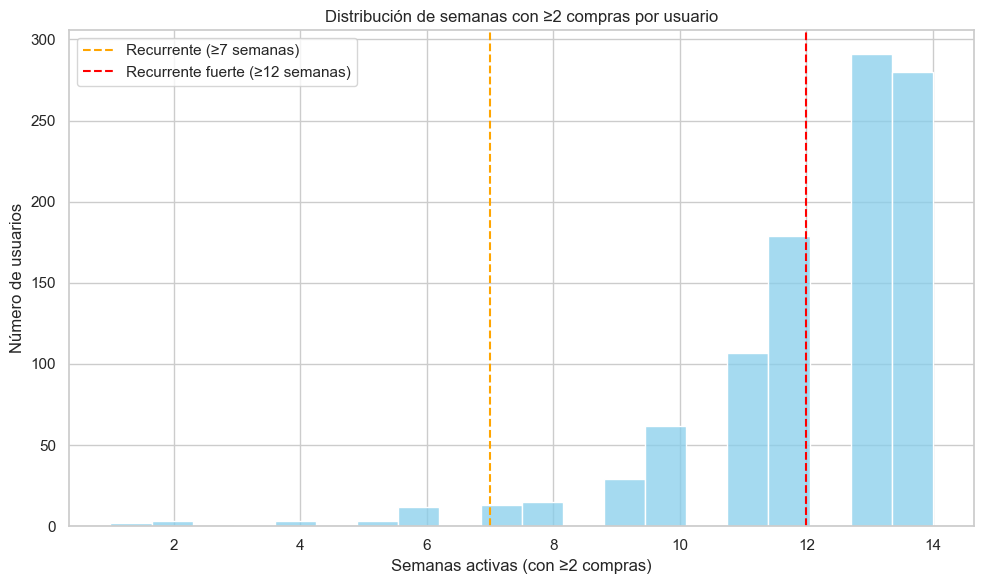

Total de usuarios: 1000
No recurrentes: 24 (2.4%)
Recurrentes: 226 (22.6%)
Recurrentes fuertes: 750 (75.0%)


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histograma con líneas verticales
plt.figure(figsize=(10, 6))
sns.histplot(
    data=recuento_semanas_validas_completo,
    x='semanas_con_2_o_mas_compras',
    bins=20,
    kde=False,
    color='skyblue'
)

# Líneas verticales
plt.axvline(x=7, color='orange', linestyle='--', label='Recurrente (≥7 semanas)')
plt.axvline(x=12, color='red', linestyle='--', label='Recurrente fuerte (≥12 semanas)')

# Estética
plt.title('Distribución de semanas con ≥2 compras por usuario')
plt.xlabel('Semanas activas (con ≥2 compras)')
plt.ylabel('Número de usuarios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Porcentajes
total = len(recuento_semanas_validas_completo)
no_recurrentes = ((recuento_semanas_validas_completo['es_recurrente'] == 0)).sum()
recurrentes = ((recuento_semanas_validas_completo['es_recurrente'] == 1) & (recuento_semanas_validas_completo['es_recurrente_fuerte'] == 0)).sum()
fuertes = (recuento_semanas_validas_completo['es_recurrente_fuerte'] == 1).sum()

print(f"Total de usuarios: {total}")
print(f"No recurrentes: {no_recurrentes} ({no_recurrentes / total:.1%})")
print(f"Recurrentes: {recurrentes} ({recurrentes / total:.1%})")
print(f"Recurrentes fuertes: {fuertes} ({fuertes / total:.1%})")
